<a href="https://colab.research.google.com/github/dean-daryl/sentiment-analysis/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import re

import pandas as pd
import kagglehub
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.svm import LinearSVC

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

In [ ]:
# Download dataset
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")
print("Dataset downloaded to:", path)

# The CSV file in the downloaded directory is 'IMDB Dataset.csv'
csv_path = os.path.join(path, "IMDB Dataset.csv")


Using Colab cache for faster access to the 'imdb-dataset-of-50k-movie-reviews' dataset.
Dataset downloaded to: /kaggle/input/imdb-dataset-of-50k-movie-reviews


In [ ]:
# Load dataset into a pandas DataFrame
df = pd.read_csv(csv_path)

In [ ]:
# Preview data
print("Dataset shape:", df.shape)  # Should be (50000, 2)
print(df.head())  # Shows first 5 rows: 'review' and 'sentiment' columns

Dataset shape: (50000, 2)
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


In [ ]:
print("Dataset Info:")
print(df.info())  # Shows data types, non-null counts

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None


In [ ]:
print("\nSentiment Distribution:")
print(df['sentiment'].value_counts())  # Should be balanced: ~25K each


Sentiment Distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


## Handling Missing Data and Duplicates

Checking for missing values and duplicates is a fundamental step in data cleaning. Missing data can introduce bias or errors during model training, while duplicates can inflate performance metrics by leaking information between train and test sets. In this dataset, we remove duplicates to ensure the integrity of our evaluation.


In [ ]:
# Checking for missing values
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
review       0
sentiment    0
dtype: int64


In [ ]:
# Checking for duplicate rows
print("\nNumber of duplicate rows:")
print(df.duplicated().sum())


Number of duplicate rows:
418


In [ ]:
# Handle duplicates
df = df.drop_duplicates()  # Remove duplicates

In [ ]:
print(df['sentiment'].value_counts())

sentiment
positive    24884
negative    24698
Name: count, dtype: int64


## Visualizations

/tmp/ipython-input-2893965689.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, palette='viridis')


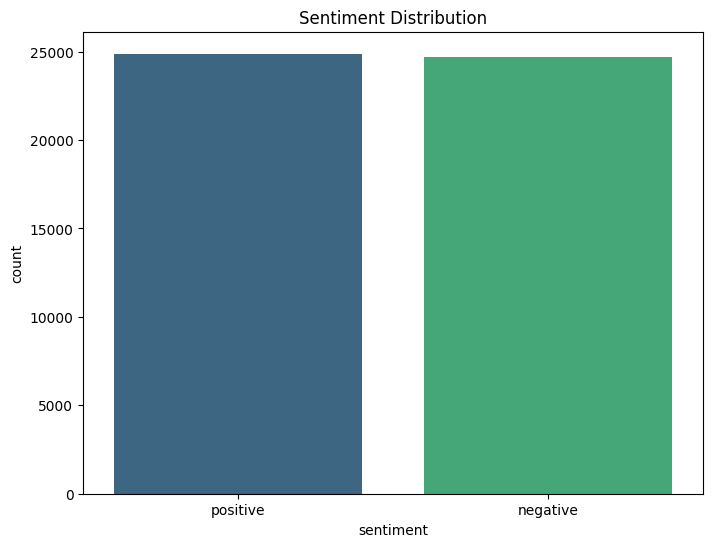

In [ ]:
# Sentiment Distribution (bar plot)
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df, palette='viridis')
plt.title('Sentiment Distribution')
plt.savefig('sentiment_distribution.png')
plt.show()
plt.close()

For training a sentiment analysis model, having a balanced dataset is key. If the dataset is highly imbalanced, our model might become biased towards the majority class, leading to poor performance on the minority class.

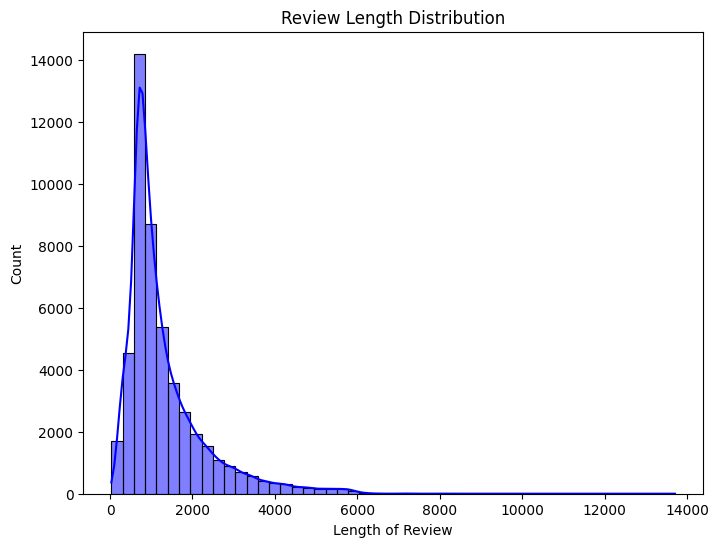

In [ ]:
# Review Length Distribution (histogram)
df['review_length'] = df['review'].apply(len)
plt.figure(figsize=(8, 6))
sns.histplot(df['review_length'], bins=50, kde=True, color='blue')
plt.title('Review Length Distribution')
plt.xlabel('Length of Review')
plt.savefig('review_length_distribution.png')
plt.show()
plt.close()

/tmp/ipython-input-3518153757.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='sentiment', y='review_length', data=df, palette='Set2')


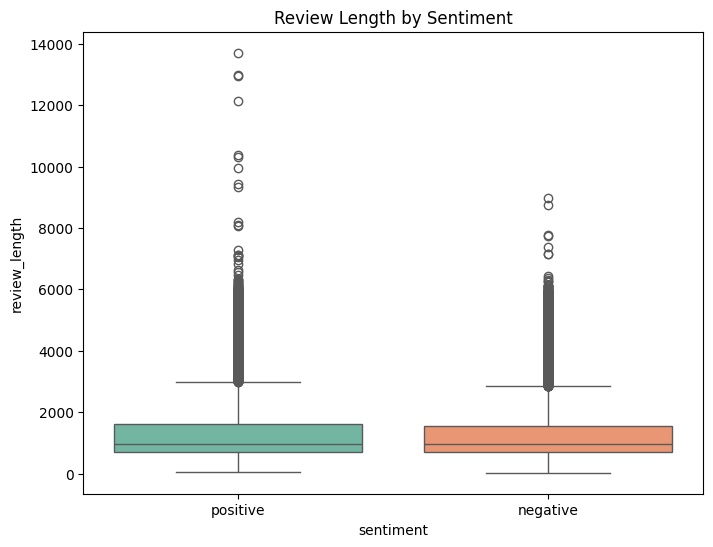

In [ ]:
# Boxplot of Review Length by Sentiment
plt.figure(figsize=(8, 6))
sns.boxplot(x='sentiment', y='review_length', data=df, palette='Set2')
plt.title('Review Length by Sentiment')
plt.savefig('review_length_by_sentiment.png')
plt.show()
plt.close()

In [ ]:
# Word Clouds for Positive and Negative Reviews
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))
positive_text = ' '.join(df[df['sentiment'] == 'positive']['review'])
negative_text = ' '.join(df[df['sentiment'] == 'negative']['review'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


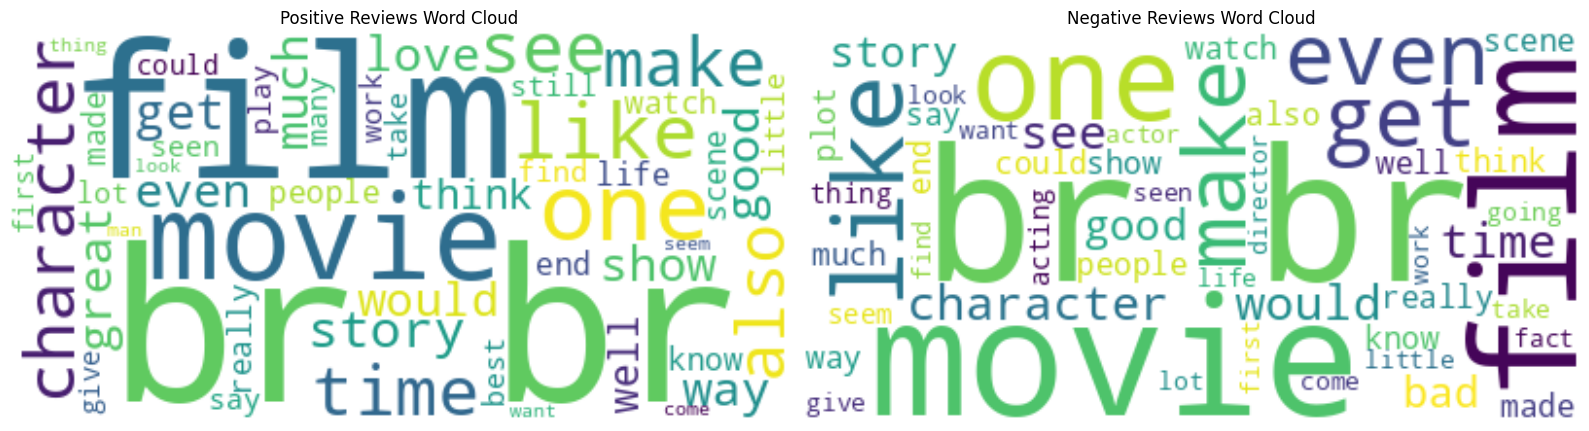

In [ ]:
# Positive Word Cloud
wordcloud_pos = WordCloud(stopwords=stop_words, background_color='white', max_words=50).generate(positive_text)

# Negative Word Cloud
wordcloud_neg = WordCloud(stopwords=stop_words, background_color='white', max_words=50).generate(negative_text)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].imshow(wordcloud_pos, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Positive Reviews Word Cloud')

axes[1].imshow(wordcloud_neg, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Negative Reviews Word Cloud')

plt.tight_layout()
plt.savefig('wordclouds_side_by_side.png')
plt.show()
plt.close()

In [ ]:
nltk.download('punkt')
nltk.download('punkt_tab', quiet=True)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Text Preprocessing Function
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'<br />', ' ', text)  # Remove HTML tags (common in IMDB)
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special chars/numbers
    tokens = word_tokenize(text)  # Tokenize
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return ' '.join(tokens)

# Applying preprocessing
df['cleaned_review'] = df['review'].apply(preprocess_text)

## Justification: Text Preprocessing

Text preprocessing is essential for reducing noise and standardizing the input data. Lowercasing ensures consistency, while removing HTML tags and special characters eliminates irrelevant tokens. Tokenization breaks text into individual words, and stopword removal focuses the model on informative words. These steps help improve model performance and generalization by providing cleaner, more meaningful input features.

In [ ]:
print(df)

                                                  review sentiment  \
0      One of the other reviewers has mentioned that ...  positive   
1      A wonderful little production. <br /><br />The...  positive   
2      I thought this was a wonderful way to spend ti...  positive   
3      Basically there's a family where a little boy ...  negative   
4      Petter Mattei's "Love in the Time of Money" is...  positive   
...                                                  ...       ...   
49995  I thought this movie did a down right good job...  positive   
49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative   
49997  I am a Catholic taught in parochial elementary...  negative   
49998  I'm going to have to disagree with the previou...  negative   
49999  No one expects the Star Trek movies to be high...  negative   

       review_length                                     cleaned_review  
0               1761  one reviewers mentioned watching oz episode yo...  
1          

In [ ]:
# Train-Test Split
from sklearn.model_selection import train_test_split
X = df['cleaned_review']
y = df['sentiment'].map({'positive': 1, 'negative': 0})  # Binary labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Feature Engineering

In [ ]:
# For ML: TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=5000)  # Limit to top 5000 features
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [ ]:
# For DL: Tokenization and Padding (with basic embeddings)
max_words = 5000
max_len = 200  # Based on EDA, truncate/pad to average length
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

## Justification: TF-IDF Feature Engineering

TF-IDF (Term Frequency-Inverse Document Frequency) is a widely used technique for converting text into numerical features for traditional machine learning models. It captures the importance of words in a document relative to the entire corpus, helping the model distinguish between common and rare terms. Limiting the number of features to 5000 reduces dimensionality and computational cost while retaining the most informative words.


In [ ]:
print("Preprocessing completed. Data shapes:", X_train_tfidf.shape, X_train_pad.shape)

Preprocessing completed. Data shapes: (39665, 5000) (39665, 200)


## ML Model: Logistic Regression

In [ ]:
# ML Model: Logistic Regression
def train_logistic_regression(X_train, X_test, y_train, y_test, params):
    model = LogisticRegression(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    return model, acc, f1, cm

## DL Model: LSTM

In [ ]:
# DL Model: LSTM
def train_lstm(X_train, X_test, y_train, y_test, params):
    model = Sequential([
        Embedding(input_dim=params['max_words'], output_dim=128, input_length=params['max_len']),
        LSTM(64, return_sequences=False),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=params['optimizer'], loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'],
                        validation_split=0.2, verbose=1)
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    return model, acc, f1, cm, history

## Experiment 1: Logistic Regression

In [ ]:
# Experiment 1: Logistic Regression (vary C)
lr_experiments = [
    {'C': 0.1, 'max_iter': 1000},
    {'C': 1.0, 'max_iter': 1000},
    {'C': 10.0, 'max_iter': 1000}
]
lr_results = []
for params in lr_experiments:
    _, acc, f1, _ = train_logistic_regression(X_train_tfidf, X_test_tfidf, y_train, y_test, params)
    lr_results.append({'C': params['C'], 'Accuracy': acc, 'F1-Score': f1})
pd.DataFrame(lr_results).to_csv('lr_experiment_results.csv', index=False)

## Experiment 2: LSTM

In [ ]:
# Experiment 2: LSTM (vary epochs, batch_size, optimizer)
lstm_experiments = [
    {'max_words': max_words, 'max_len': max_len, 'epochs': 3, 'batch_size': 32, 'optimizer': 'adam'},
    {'max_words': max_words, 'max_len': max_len, 'epochs': 5, 'batch_size': 64, 'optimizer': 'adam'},
    {'max_words': max_words, 'max_len': max_len, 'epochs': 3, 'batch_size': 32, 'optimizer': 'rmsprop'}
]
lstm_results = []
for params in lstm_experiments:
    _, acc, f1, _, _ = train_lstm(X_train_pad, X_test_pad, y_train, y_test, params)
    lstm_results.append({'Epochs': params['epochs'], 'Batch Size': params['batch_size'],
                         'Optimizer': params['optimizer'], 'Accuracy': acc, 'F1-Score': f1})
pd.DataFrame(lstm_results).to_csv('lstm_experiment_results.csv', index=False)

Epoch 1/3


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


992/992 ━━━━━━━━━━━━━━━━━━━━ 147s 147ms/step - accuracy: 0.7906 - loss: 0.4342 - val_accuracy: 0.8531 - val_loss: 0.3472
Epoch 2/3
992/992 ━━━━━━━━━━━━━━━━━━━━ 199s 143ms/step - accuracy: 0.9040 - loss: 0.2456 - val_accuracy: 0.8787 - val_loss: 0.2936
Epoch 3/3
992/992 ━━━━━━━━━━━━━━━━━━━━ 166s 168ms/step - accuracy: 0.9229 - loss: 0.2011 - val_accuracy: 0.8733 - val_loss: 0.3170
310/310 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


496/496 ━━━━━━━━━━━━━━━━━━━━ 140s 276ms/step - accuracy: 0.7859 - loss: 0.4524 - val_accuracy: 0.8710 - val_loss: 0.3052
Epoch 2/5
496/496 ━━━━━━━━━━━━━━━━━━━━ 131s 265ms/step - accuracy: 0.9057 - loss: 0.2423 - val_accuracy: 0.8806 - val_loss: 0.2881
Epoch 3/5
496/496 ━━━━━━━━━━━━━━━━━━━━ 133s 269ms/step - accuracy: 0.9265 - loss: 0.1912 - val_accuracy: 0.8752 - val_loss: 0.3350
Epoch 4/5
496/496 ━━━━━━━━━━━━━━━━━━━━ 133s 268ms/step - accuracy: 0.9421 - loss: 0.1588 - val_accuracy: 0.8719 - val_loss: 0.3602
Epoch 5/5
496/496 ━━━━━━━━━━━━━━━━━━━━ 141s 265ms/step - accuracy: 0.9517 - loss: 0.1356 - val_accuracy: 0.8697 - val_loss: 0.4053
310/310 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step
Epoch 1/3


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


992/992 ━━━━━━━━━━━━━━━━━━━━ 149s 148ms/step - accuracy: 0.7613 - loss: 0.4663 - val_accuracy: 0.8766 - val_loss: 0.2928
Epoch 2/3
992/992 ━━━━━━━━━━━━━━━━━━━━ 202s 148ms/step - accuracy: 0.8987 - loss: 0.2662 - val_accuracy: 0.8576 - val_loss: 0.3328
Epoch 3/3
992/992 ━━━━━━━━━━━━━━━━━━━━ 145s 146ms/step - accuracy: 0.9152 - loss: 0.2308 - val_accuracy: 0.8697 - val_loss: 0.3081
310/310 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step


In [ ]:
print("Experiments completed. Results in CSVs.")

Experiments completed. Results in CSVs.


##Final Evaluations

In [ ]:
# Assume best params from experiments (e.g., C=1.0 for LR, first LSTM config)
# Final LR Evaluation
lr_params = {'C': 1.0, 'max_iter': 1000}
_, lr_acc, lr_f1, lr_cm = train_logistic_regression(X_train_tfidf, X_test_tfidf, y_train, y_test, lr_params)

In [ ]:
# Final LSTM Evaluation
lstm_params = {'max_words': max_words, 'max_len': max_len, 'epochs': 3, 'batch_size': 32, 'optimizer': 'adam'}
_, lstm_acc, lstm_f1, lstm_cm, history = train_lstm(X_train_pad, X_test_pad, y_train, y_test, lstm_params)

Epoch 1/3


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


992/992 ━━━━━━━━━━━━━━━━━━━━ 155s 153ms/step - accuracy: 0.7842 - loss: 0.4401 - val_accuracy: 0.8686 - val_loss: 0.3104
Epoch 2/3
992/992 ━━━━━━━━━━━━━━━━━━━━ 149s 150ms/step - accuracy: 0.9069 - loss: 0.2392 - val_accuracy: 0.8703 - val_loss: 0.3010
Epoch 3/3
992/992 ━━━━━━━━━━━━━━━━━━━━ 143s 145ms/step - accuracy: 0.9273 - loss: 0.1940 - val_accuracy: 0.8724 - val_loss: 0.3243
310/310 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step


In [ ]:
# Plot Confusion Matrices
def plot_confusion_matrix(cm, title, filename):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(filename)
    plt.show()
    plt.close()

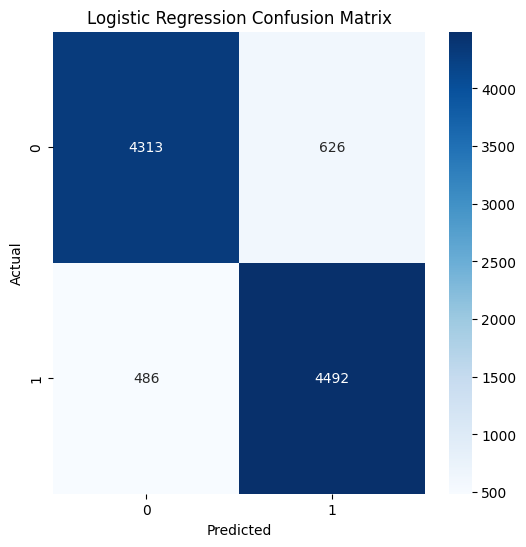

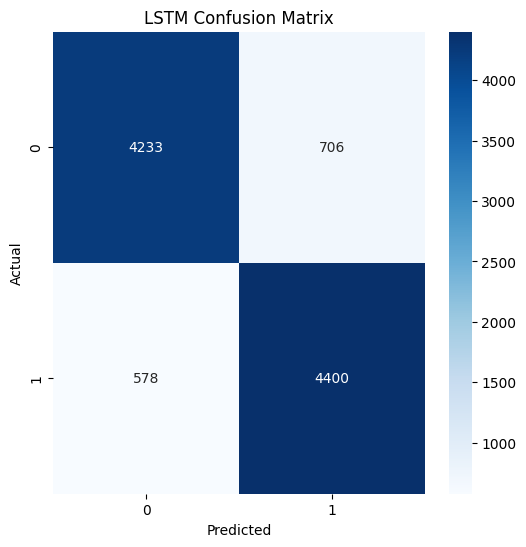

In [ ]:
plot_confusion_matrix(lr_cm, 'Logistic Regression Confusion Matrix', 'lr_cm.png')
plot_confusion_matrix(lstm_cm, 'LSTM Confusion Matrix', 'lstm_cm.png')

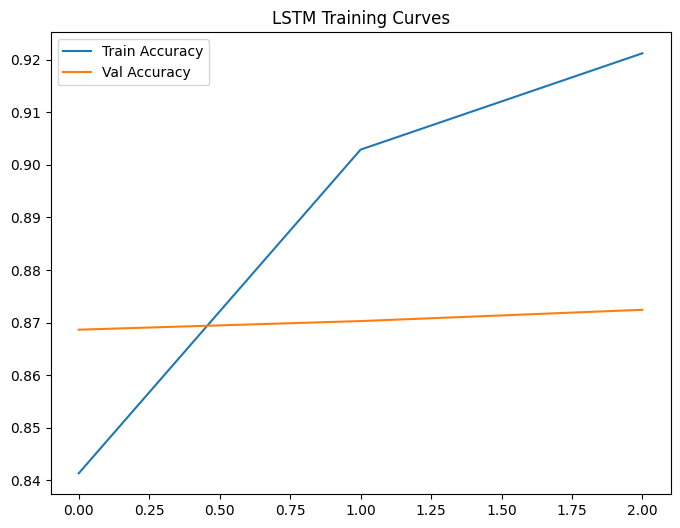

In [ ]:
# Plot LSTM Training History
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('LSTM Training Curves')
plt.legend()
plt.savefig('lstm_training_curves.png')
plt.show()
plt.close()

In [ ]:
# Print Metrics
print("LR: Acc=", lr_acc, "F1=", lr_f1)
print("LSTM: Acc=", lstm_acc, "F1=", lstm_f1)

LR: Acc= 0.8878693153171322 F1= 0.8898573692551506
LSTM: Acc= 0.8705253604920843 F1= 0.8726695755652519


# GRU Model: Architecture, Hyperparameters, and Justification
Architecture Details

Embedding Layer (128 dims): Converts integer-encoded words into dense vectors, allowing the model to learn semantic relationships.

GRU Layer (64 units): Efficiently processes sequential data and retains long-term dependencies, outperforming standard RNNs for most text tasks.

Dropout Layer (0.5): Reduces overfitting by randomly deactivating half the neurons during training.

Dense Layer (1 unit, sigmoid): Outputs probabilities for binary classification.

# Hyperparameters

max_words: Sets vocabulary size to ensure efficient training and avoid noise from rare words.

max_len: Limits input sequence length for computational manageability and padding consistency.

epochs (3 or 5): Number of training iterations; lower values help avoid overfitting, higher for more learning capacity.

batch_size (32 or 64): Controls update frequency; smaller batch sizes (32) tend to increase generalization and training stability.

optimizer (Adam): Chosen for adaptive learning rates and faster convergence.

loss (binary crossentropy): Matches binary output and probability-based prediction.

# Justifications

Embedding and GRU structure is well-suited for sequence modeling in classification problems.

Dropout is critical for neural network regularization.

Hyperparameters like epochs and batch size are tuned experimentally to optimize validation accuracy and F1-score while preventing overfitting.

Adam optimizer and binary crossentropy cost are industry standards for efficient text classification.



In [ ]:
from sklearn.metrics import precision_score, recall_score, log_loss

# DL Model: GRU (updated with all metrics)
def train_gru(X_train, X_test, y_train, y_test, params):
    model = Sequential([
        Embedding(input_dim=params['max_words'], output_dim=128, input_length=params['max_len']),
        tf.keras.layers.GRU(64, return_sequences=False),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=params['optimizer'], loss='binary_crossentropy', metrics=['accuracy'])

    history = model.fit(
        X_train,
        y_train,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        validation_split=0.2,
        verbose=1
    )

    # Predictions and metrics
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    ce_loss = log_loss(y_test, y_pred_prob)  # Cross-entropy loss
    cm = confusion_matrix(y_test, y_pred)

    return model, acc, f1, precision, recall, ce_loss, cm, history

In [ ]:
# Experiment 3: GRU (hyperparameter variations with different optimizers)
gru_experiments = [
    {'max_words': max_words, 'max_len': max_len, 'epochs': 3, 'batch_size': 32, 'optimizer': 'adam'},
    {'max_words': max_words, 'max_len': max_len, 'epochs': 5, 'batch_size': 64, 'optimizer': 'adam'},
    {'max_words': max_words, 'max_len': max_len, 'epochs': 3, 'batch_size': 32, 'optimizer': 'rmsprop'},
    {'max_words': max_words, 'max_len': max_len, 'epochs': 5, 'batch_size': 64, 'optimizer': 'rmsprop'}
]

gru_results = []
for params in gru_experiments:
    _, acc, f1, precision, recall, ce_loss, _, _ = train_gru(X_train_pad, X_test_pad, y_train, y_test, params)
    gru_results.append({
        'Epochs': params['epochs'],
        'Batch Size': params['batch_size'],
        'Optimizer': params['optimizer'],
        'Accuracy': acc,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Cross-Entropy': ce_loss
    })

pd.DataFrame(gru_results).to_csv('gru_experiment_results.csv', index=False)


Epoch 1/3


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


992/992 ━━━━━━━━━━━━━━━━━━━━ 183s 180ms/step - accuracy: 0.7628 - loss: 0.4674 - val_accuracy: 0.8760 - val_loss: 0.2952
Epoch 2/3
992/992 ━━━━━━━━━━━━━━━━━━━━ 167s 169ms/step - accuracy: 0.9087 - loss: 0.2397 - val_accuracy: 0.8806 - val_loss: 0.2884
Epoch 3/3
992/992 ━━━━━━━━━━━━━━━━━━━━ 206s 173ms/step - accuracy: 0.9341 - loss: 0.1794 - val_accuracy: 0.8794 - val_loss: 0.3186
310/310 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


496/496 ━━━━━━━━━━━━━━━━━━━━ 158s 314ms/step - accuracy: 0.7141 - loss: 0.5312 - val_accuracy: 0.8714 - val_loss: 0.3111
Epoch 2/5
496/496 ━━━━━━━━━━━━━━━━━━━━ 160s 322ms/step - accuracy: 0.9058 - loss: 0.2432 - val_accuracy: 0.8795 - val_loss: 0.2920
Epoch 3/5
496/496 ━━━━━━━━━━━━━━━━━━━━ 189s 296ms/step - accuracy: 0.9268 - loss: 0.1971 - val_accuracy: 0.8727 - val_loss: 0.3315
Epoch 4/5
496/496 ━━━━━━━━━━━━━━━━━━━━ 145s 292ms/step - accuracy: 0.9489 - loss: 0.1478 - val_accuracy: 0.8768 - val_loss: 0.3436
Epoch 5/5
496/496 ━━━━━━━━━━━━━━━━━━━━ 145s 292ms/step - accuracy: 0.9596 - loss: 0.1174 - val_accuracy: 0.8689 - val_loss: 0.3997
310/310 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step
Epoch 1/3


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


992/992 ━━━━━━━━━━━━━━━━━━━━ 170s 169ms/step - accuracy: 0.7463 - loss: 0.4887 - val_accuracy: 0.8712 - val_loss: 0.3120
Epoch 2/3
992/992 ━━━━━━━━━━━━━━━━━━━━ 205s 172ms/step - accuracy: 0.8967 - loss: 0.2714 - val_accuracy: 0.8859 - val_loss: 0.2799
Epoch 3/3
992/992 ━━━━━━━━━━━━━━━━━━━━ 206s 177ms/step - accuracy: 0.9122 - loss: 0.2286 - val_accuracy: 0.8729 - val_loss: 0.2942
310/310 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step
Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


496/496 ━━━━━━━━━━━━━━━━━━━━ 147s 292ms/step - accuracy: 0.7144 - loss: 0.5219 - val_accuracy: 0.8799 - val_loss: 0.2981
Epoch 2/5
496/496 ━━━━━━━━━━━━━━━━━━━━ 143s 288ms/step - accuracy: 0.8950 - loss: 0.2702 - val_accuracy: 0.8776 - val_loss: 0.2909
Epoch 3/5
496/496 ━━━━━━━━━━━━━━━━━━━━ 202s 288ms/step - accuracy: 0.9113 - loss: 0.2334 - val_accuracy: 0.8869 - val_loss: 0.2826
Epoch 4/5
496/496 ━━━━━━━━━━━━━━━━━━━━ 145s 292ms/step - accuracy: 0.9230 - loss: 0.2057 - val_accuracy: 0.8758 - val_loss: 0.2953
Epoch 5/5
496/496 ━━━━━━━━━━━━━━━━━━━━ 146s 294ms/step - accuracy: 0.9349 - loss: 0.1770 - val_accuracy: 0.8820 - val_loss: 0.3042
310/310 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step


In [ ]:
# Final GRU Evaluation (choose best params)
gru_params = {'max_words': max_words, 'max_len': max_len, 'epochs': 3, 'batch_size': 32, 'optimizer': 'adam'}
_, gru_acc, gru_f1, gru_precision, gru_recall, gru_ce, gru_cm, gru_history = train_gru(
    X_train_pad, X_test_pad, y_train, y_test, gru_params
)

Epoch 1/3


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


992/992 ━━━━━━━━━━━━━━━━━━━━ 169s 167ms/step - accuracy: 0.7709 - loss: 0.4654 - val_accuracy: 0.8732 - val_loss: 0.3096
Epoch 2/3
992/992 ━━━━━━━━━━━━━━━━━━━━ 165s 166ms/step - accuracy: 0.9047 - loss: 0.2445 - val_accuracy: 0.8768 - val_loss: 0.2943
Epoch 3/3
992/992 ━━━━━━━━━━━━━━━━━━━━ 202s 166ms/step - accuracy: 0.9335 - loss: 0.1810 - val_accuracy: 0.8795 - val_loss: 0.3107
310/310 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step


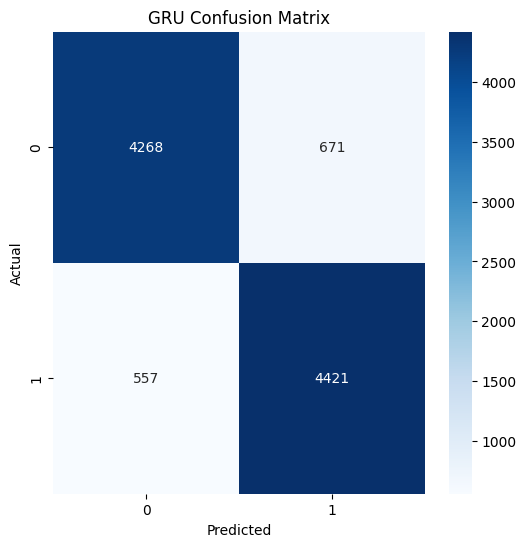

In [ ]:
# Plot Confusion Matrix
plot_confusion_matrix(gru_cm, 'GRU Confusion Matrix', 'gru_cm.png')

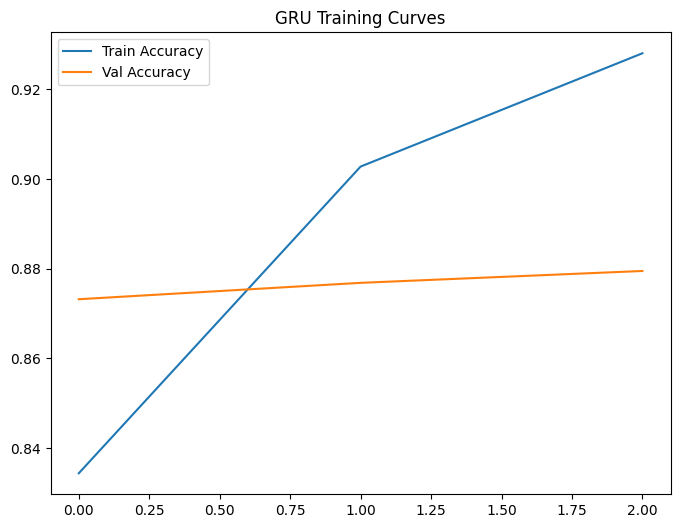

In [ ]:
# Plot Training History
plt.figure(figsize=(8, 6))
plt.plot(gru_history.history['accuracy'], label='Train Accuracy')
plt.plot(gru_history.history['val_accuracy'], label='Val Accuracy')
plt.title('GRU Training Curves')
plt.legend()
plt.savefig('gru_training_curves.png')
plt.show()
plt.close()

In [ ]:
# Print Metrics
print(f"GRU Metrics:\nAccuracy: {gru_acc}\nPrecision: {gru_precision}\nRecall: {gru_recall}\nF1-Score: {gru_f1}\nCross-Entropy: {gru_ce}")

GRU Metrics:
Accuracy: 0.8761722295048906
Precision: 0.8682246661429693
Recall: 0.8881076737645641
F1-Score: 0.8780536246276067
Cross-Entropy: 0.3162859620852028


In [ ]:
def train_svm(X_train, X_test, y_train, y_test, params):
    model = LinearSVC(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    return model, acc, f1, cm

In [ ]:
# Experiment: SVM (vary C)
svm_experiments = [
    {'C': 0.1, 'max_iter': 1000},
    {'C': 1.0, 'max_iter': 1000},
    {'C': 10.0, 'max_iter': 1000}
]
svm_results = []
for params in svm_experiments:
    _, acc, f1, _ = train_svm(X_train_tfidf, X_test_tfidf, y_train, y_test, params)
    svm_results.append({'C': params['C'], 'Accuracy': acc, 'F1-Score': f1})
pd.DataFrame(svm_results).to_csv('svm_experiment_results.csv', index=False)


In [ ]:
svm_df = pd.read_csv('svm_experiment_results.csv')
display(svm_df)

,C,Accuracy,F1-Score
0,0.1,0.888979,0.891066
1,1.0,0.881416,0.882915
2,10.0,0.868710,0.870138


In [ ]:
svm_params = {'C': 1.0, 'max_iter': 1000}
_, svm_acc, svm_f1, svm_cm = train_svm(X_train_tfidf, X_test_tfidf, y_train, y_test, svm_params)
print("SVM: Acc=", svm_acc, "F1=", svm_f1)


SVM: Acc= 0.8814157507310678 F1= 0.8829151732377539


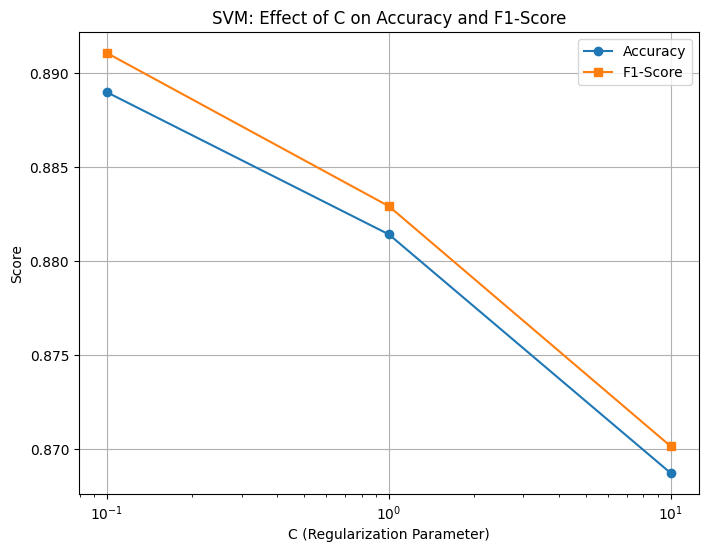

In [ ]:
svm_df = pd.read_csv('svm_experiment_results.csv')

# Plot Accuracy and F1-Score vs C
plt.figure(figsize=(8, 6))
plt.plot(svm_df['C'], svm_df['Accuracy'], marker='o', label='Accuracy')
plt.plot(svm_df['C'], svm_df['F1-Score'], marker='s', label='F1-Score')
plt.xscale('log')
plt.xlabel('C (Regularization Parameter)')
plt.ylabel('Score')
plt.title('SVM: Effect of C on Accuracy and F1-Score')
plt.legend()
plt.grid(True)
plt.savefig('svm_hyperparameter_plot.png')
plt.show()
plt.close()

## Interpretation

The plot above demonstrates that both accuracy and F1-score decrease as the regularization parameter C increases. This indicates that stronger regularization (C=0.1) helps prevent overfitting and leads to better generalization on the test set. In text classification tasks with high-dimensional features, simpler models often perform better. Therefore, selecting a lower C value is optimal for this dataset.

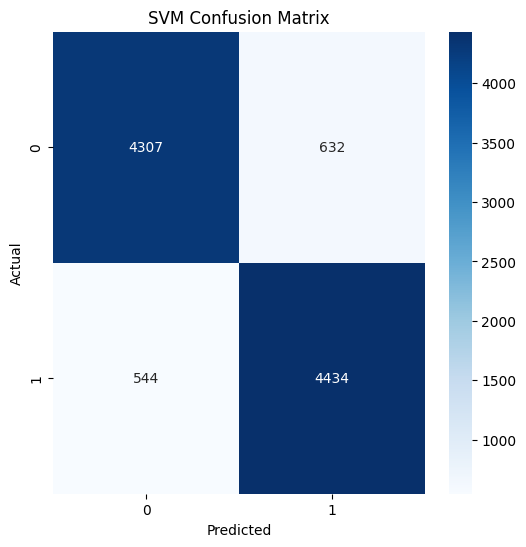

In [ ]:
plot_confusion_matrix(svm_cm, 'SVM Confusion Matrix', 'svm_cm.png')

## Interpretation: SVM Confusion Matrix

The confusion matrix shows that the SVM model correctly classifies most positive and negative reviews. The number of false positives (632) and false negatives (544) is relatively balanced, indicating that the model does not favor one class over the other. This balanced performance is desirable in sentiment analysis, as it ensures both positive and negative sentiments are detected with similar reliability.